# Leukemia Classification by Gene Expressions

In this notebook I will be looking at a high-dimensional dataset comprising gene expressions and build a classification model to predict two types of leukemia: acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL). The dataset was used in the following paper:

Golu, et al. $\textit{Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression}$, Science, 15 Oct. 1999, Vol. 286, Issue 5439, pp. 531-537. More information about the study is found [here](http://science.sciencemag.org/content/286/5439/531)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

np.random.seed(9001)

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/AtanasiuDemian/a-2017/master/hwassets/data/dataset_hw5.csv')
df.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
1,0,-135,-114,265,12,-419,-585,158,-253,49,...,240,835,218,174,-110,627,170,-50,126,-91
2,0,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25
3,0,-72,-144,238,55,-399,-551,131,-179,126,...,30,819,-178,151,-18,1140,482,10,369,-42
4,0,-413,-260,7,-2,-541,-790,-275,-463,70,...,289,629,-86,302,23,1798,446,59,781,20


In [3]:
msk = np.random.rand(len(df)) < 0.5
train = df[msk]
test = df[~msk]
train.shape, test.shape

((32, 7130), (41, 7130))

In [4]:
train.shape, test.shape

((32, 7130), (41, 7130))

The data contains 7129 gene measurements for 72 pacients, hence we have a very high ratio of number of predictors to number of samples.

Before building a classification model, I will normalize all predictors:

In [5]:
train_min, train_max = train.min(), train.max()
train = (train - train.min())/(train.max() - train.min())
test = (test - test.min())/(test.max() - test.min())

For visualizing the data we can use Principal Components Analysis (PCA). By plotting the first and second principal components against each other, we can obtain a two-dimensional representation of the data that captures most of the variance.

In [6]:
# Compute the principal components
pca = PCA(n_components=2)
predictors = train.drop('Cancer_type', axis=1).columns
data_train_pca = pca.fit_transform(train[predictors])
dfpca=pd.DataFrame(dict(Cancer_type=train.Cancer_type))
for i in range(data_train_pca.shape[1]):
    dfpca['PC%d'%(i+1)]=data_train_pca[:,i]
dfpca.head()

,Cancer_type,PC1,PC2
0,0.0,7.667012,-0.181414
5,0.0,-8.705269,-3.125841
9,0.0,21.341975,8.695756
12,0.0,11.527633,23.669014
13,0.0,-7.842507,7.473386


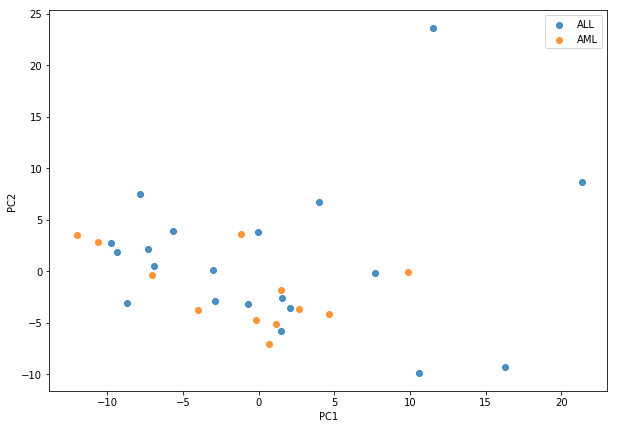

In [7]:
labels = ['ALL', 'AML']
fig, ax = plt.subplots(1,1,figsize=(10,7))
for l in dfpca.Cancer_type.unique():
    mask = dfpca.Cancer_type==l
    ax.scatter(dfpca[mask]['PC1'], dfpca[mask]['PC2'], label=labels[int(l)], alpha=0.8)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc='best')

It looks like we can't really separate the points clearly.

## 1 . Simple Logistic Regression

In [8]:
X_train, y_train = train.drop('Cancer_type', axis=1), train['Cancer_type']
X_test, y_test = test.drop('Cancer_type', axis=1), test['Cancer_type']

logreg = LogisticRegression(C=10000000)
logreg.fit(X_train[['D29963_at']], y_train)
y_pred_train = logreg.predict(X_train[['D29963_at']])
y_pred_test = logreg.predict(X_test[['D29963_at']])
print('Accuracy on training set: {}\nAccuracy on test set: {}'.format(accuracy_score(y_train, y_pred_train),
                                                                     accuracy_score(y_test, y_pred_test)))

Accuracy on training set: 0.71875
Accuracy on test set: 0.8292682926829268


In [9]:
msk = y_pred_test==1.0
aml_vals = X_test.loc[msk, 'D29963_at'].values.reshape(-1,1)
all_vals = X_test[~msk]['D29963_at'].values.reshape(-1,1)

Plot the predicted probabilities versus the real data, on the test set:

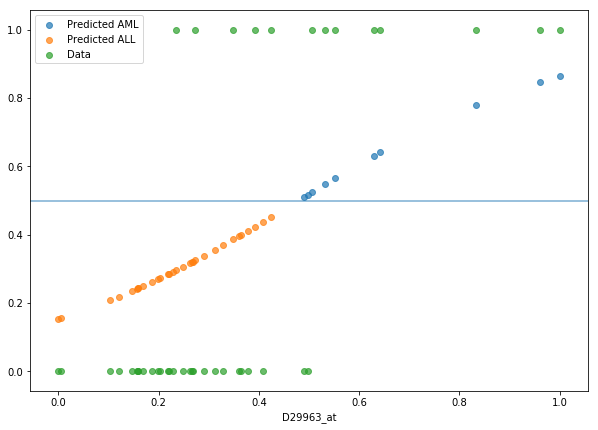

In [10]:
plt.figure(figsize=(10,7))
plt.scatter(aml_vals, logreg.predict_proba(aml_vals)[:,1], label = 'Predicted AML', alpha=0.7)
plt.scatter(all_vals, logreg.predict_proba(all_vals)[:,1], label='Predicted ALL', alpha=0.7)
plt.scatter(X_test['D29963_at'], y_test, label='Data', alpha=0.7)
plt.axhline(y=0.5, alpha=0.6)
plt.xlabel('D29963_at')
plt.legend(loc='best')

The classification report and confusion matrix are shown below:

In [11]:
print(classification_report(y_test, y_pred_test))

             precision    recall  f1-score   support

        0.0       0.84      0.93      0.88        28
        1.0       0.80      0.62      0.70        13

avg / total       0.83      0.83      0.82        41



In [12]:
print(confusion_matrix(y_test, y_pred_test))

[[26  2]
 [ 5  8]]


Using the simple logistic model on the test set, we correctly classified 26 pacients with ALL and 8 pacients with AML, and misclassified 2 pacients with ALL (i.e. the model predicted AML) and 5 pacients with AML.

## 2 . Multiple Logistic Regression

I will now fit a multiple logistic regression model using all gene predictors:

In [13]:
mult_logreg = LogisticRegression(C=100000)
mult_logreg.fit(X_train, y_train)
mlog_y_pred_train = mult_logreg.predict(X_train)
mlog_y_pred_test = mult_logreg.predict(X_test)
print('Accuracy on training set: {}\nAccuracy on test set: {}'.format(accuracy_score(y_train, mlog_y_pred_train),
                                                                     accuracy_score(y_test, mlog_y_pred_test)))

Accuracy on training set: 1.0
Accuracy on test set: 0.926829268292683


This model has better performance than the simple logistic one.

In [14]:
confusion_matrix(y_test, mlog_y_pred_test)

array([[28,  0],
       [ 3, 10]], dtype=int64)

## 3 . Significance of coefficients

In this subsection I will look at the significance of the multiple logistic regression coefficients at 0.05 level. A significance level of 0.05 means there is a probability of at most 0.05 of concluding that a regression coefficient is non-zero, when actually it is null (i.e. does not contribute to the model). This is equivalent to looking at the 95% confidence interval for a coefficient and rejecting the null hypothesis (which states that the regression coefficient is null) if this confidence interval does not contain 0. Given the dimensions of the dataset, I will use bootstrapping with 100 sample drawings.

In [15]:
coeffs=np.zeros((100, X_train.shape[1]+1))
for k in range(100):
    boot_logistic = LogisticRegression(C=100000)
    sample_ind = np.random.choice(range(len(y_train)), size=len(y_train), replace=True)
    X_train_sample, y_train_sample = X_train.values[sample_ind], y_train.values[sample_ind]
    boot_logistic.fit(X_train_sample, y_train_sample)
    all_coeffs = np.append(boot_logistic.coef_, boot_logistic.intercept_)
    coeffs[k, :] = all_coeffs

For each coefficient we have 100 values, from each sampling. Compute the 95% confidence interval by computing the 97.5 and 2.5 percentiles:

In [16]:
# Compute the bootstrap confidence intervals
# Significantly different from 0 when the above C.I. does not contain 0
sig_diff = 0
for i in range(coeffs.shape[1]):
    upper_ci = np.percentile(coeffs[:,i], q=97.5)
    lower_ci = np.percentile(coeffs[:,i], q=2.5)
    if lower_ci>0 or upper_ci<0:
        sig_diff+=1
print('Number of coefficients significantly different from 0: {} out of {}'.format(sig_diff, coeffs.shape[1]))

Number of coefficients significantly different from 0: 1881 out of 7130


## 4 . Dimension Reduction via PCA

Since we have a 7129 predictors for only 32 samples, using Principal Components Analysis might provide better test set accuracy. In what follows I will fit a logistic regression model to the vector of principal components of the training set, where the number of principal components will be chosen through 5-fold cross-validation. For simplicity, I will keep the number of principal components below 30.

In [23]:
cv_scores=np.zeros((30,))
for i in range(30):
    pca = PCA(n_components=i+1)
    X_train_pca = pca.fit_transform(X_train)
    cv_scores[i] = np.mean(cross_val_score(LogisticRegression(C=100000), X=X_train_pca, y=y_train, cv=5))
opt_components = np.argmax(cv_scores)+1
print('Optimal number of principal components chosen through CV: {}'.format(opt_components))

Optimal number of principal components chosen through CV: 11


In [24]:
# Evaluate this new model on the test set
pca_opt = PCA(n_components=opt_components)
X_train_pca = pca_opt.fit_transform(X_train)
X_test_pca = pca_opt.transform(X_test)
pca_opt_logreg = LogisticRegression()
pca_opt_logreg.fit(X_train_pca, y_train)
pca_opt_y_pred_test = pca_opt_logreg.predict(X_test_pca)
print('Test set accuracy: {}'.format(accuracy_score(y_test, pca_opt_y_pred_test)))

Test set accuracy: 0.9512195121951219


In [25]:
confusion_matrix(y_test, pca_opt_y_pred_test)

array([[27,  1],
       [ 1, 12]], dtype=int64)

It looks like logistic regression + PCA only gives marginal improvement on the test set over just logistic regression.